In [1]:
import glob
import pandas as pd
fns1 = sorted(glob.glob('./1_data files/*.csv', recursive=True))
fns2 = sorted(glob.glob('./2_data files/*.csv', recursive=True))
fns3 = sorted(glob.glob('./3_data files/*.csv', recursive=True))
fns4 = sorted(glob.glob('./4_data files/*.csv', recursive=True))
dfs1 = []
dfs2 = []
dfs3 = []
dfs4 = []

for fn in fns1:
    df = pd.read_csv(fn)
    dfs1.append(df)
for fn in fns2:
    df = pd.read_csv(fn)
    dfs2.append(df)
for fn in fns3:
    df = pd.read_csv(fn)
    dfs3.append(df)
for fn in fns4:
    df = pd.read_csv(fn)
    dfs4.append(df)

In [2]:
updated_dfs1 = []
updated_dfs2 = []
updated_dfs3 = []
updated_dfs4 = []
for df in dfs1:
    df0 = df.copy()
    df0['amt'] = df0['amt'] * (df0['time'] % df0['II'] == 0)#df0.apply(lambda x: 0 if x['time'] % x['II'] != 0 else x['amt'], axis=1)
    df0 = df0.drop(index=df0.index[0])
    updated_dfs1.append(df0)
    non_zero_rows_df0 = df0[df0['amt'] != 0]
    if len(non_zero_rows_df0) !=6 :
        print('error', len(non_zero_rows_df0))
        break

for df in dfs2:
    df0 = df.copy()
    df0['amt'] = df0['amt'] * (df0['time'] % df0['II'] == 0)#df0.apply(lambda x: 0 if x['time'] % x['II'] != 0 else x['amt'], axis=1)
    df0 = df0.drop(index=df0.index[0])
    updated_dfs2.append(df0)
    non_zero_rows_df0 = df0[df0['amt'] != 0]
    if len(non_zero_rows_df0) !=6 :
        print('error', len(non_zero_rows_df0))
        break

for df in dfs3:
    df0 = df.copy()
    df0['amt'] = df0['amt'] * (df0['time'] % df0['II'] == 0)#df0.apply(lambda x: 0 if x['time'] % x['II'] != 0 else x['amt'], axis=1)
    df0 = df0.drop(index=df0.index[0])
    updated_dfs3.append(df0)
    non_zero_rows_df0 = df0[df0['amt'] != 0]
    if len(non_zero_rows_df0) !=6 :
        print('error', len(non_zero_rows_df0))
        break

for df in dfs4:
    df0 = df.copy()
    df0['amt'] = df0['amt'] * (df0['time'] % df0['II'] == 0)#df0.apply(lambda x: 0 if x['time'] % x['II'] != 0 else x['amt'], axis=1)
    df0 = df0.drop(index=df0.index[0])
    updated_dfs4.append(df0)
    non_zero_rows_df0 = df0[df0['amt'] != 0]
    if len(non_zero_rows_df0) !=6 :
        print('error', len(non_zero_rows_df0))
        break


In [3]:
boundary_idx = int(2500*0.8)
train_1, test_1 = updated_dfs1[:boundary_idx], updated_dfs1[boundary_idx:]
train_2, test_2 = updated_dfs2[:boundary_idx], updated_dfs2[boundary_idx:]
train_3, test_3 = updated_dfs3[:boundary_idx], updated_dfs3[boundary_idx:]
train_4, test_4 = updated_dfs4[:boundary_idx], updated_dfs4[boundary_idx:]

In [4]:
train_all = pd.concat(train_1 + train_2 + train_3 + train_4, axis=0)
test_all = pd.concat(test_1 + test_2 + test_3 + test_4, axis=0)

In [5]:
#train_all_amt = train_all[train_all['amt'] > 0]

In [6]:
train_all.mean(axis=0), train_all.std(axis=0)

(Unnamed: 0    1173.488696
 ID               1.000000
 time          1171.488696
 CP              44.767109
 BW              78.885446
 EGFR            84.934774
 SEX              0.352661
 RAAS             0.179839
 BPS              0.614390
 amt              0.704499
 II             468.595478
 dtype: float64,
 Unnamed: 0    782.674928
 ID              0.000000
 time          782.674928
 CP             38.482407
 BW             21.155964
 EGFR           20.620519
 SEX             0.477798
 RAAS            0.384053
 BPS             0.486739
 amt            14.369299
 II            136.261923
 dtype: float64)

In [32]:
std_sr = pd.Series({'BW': 20., 'EGFR': 20., 'SEX': 1.0, 'RAAS': 1.0,'BPS':1.0,'amt':400, 'CP':1.0, 'II':1.0})
mean_sr = pd.Series({'BW':80., 'EGFR':80,'SEX':0, 'RAAS':0,'BPS':0,'amt':0, 'CP':0, 'II':0.0})

In [49]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframes, mean_sr, std_sr):
        """
        dataframes: 리스트 형태의 pandas DataFrame. 각 데이터프레임은 길이가 다를 수 있음.
        """
        self.dataframes = dataframes
        self.mean_sr = mean_sr
        self.std_sr = std_sr
        self.data_column = mean_sr.index
    def __len__(self):
        return len(self.dataframes)

    def __getitem__(self, idx):
        # 데이터프레임을 numpy 배열로 변환하여 반환
        return (self.dataframes[idx][self.data_column] - self.mean_sr)/self.std_sr

def collate_fn(batch):
    """
    배치 내 시퀀스 길이가 다를 경우 패딩을 적용하는 함수
    """
    # 각 시퀀스의 길이를 가져오기
    lengths = [len(seq) - 1 for seq in batch]
    max_len = max(lengths)

    # 패딩 적용 (0으로 패딩)
    padded_batch_input = np.zeros((len(batch), max_len, 7), dtype=np.float32)  # (batch_size, max_len, feature_dim)
    padded_batch_label = np.zeros((len(batch), max_len, 1), dtype=np.float32)
    pad_mask = np.zeros((len(batch), max_len, 1), np.float32)

    inject_batch_input = np.zeros((len(batch), 5, 7), dtype=np.float32)
    inject_batch_label = np.zeros((len(batch), 5, 1), dtype=np.float32)
    
    for idx, seq in enumerate(batch):
        # print(seq.iloc[:-1].loc[:,['BW','EGFR', 'SEX', 'RAAS', 'BPS', 'amt']])
        assert seq['II'].iloc[0] * 5 == lengths[idx]
        padded_batch_input[idx, :lengths[idx], 1:] = seq.iloc[:-1].loc[:,['BW','EGFR', 'SEX', 'RAAS', 'BPS', 'amt']].values  # 실제 데이터 채우기
        cp_diff = seq.iloc[1:].loc[:,['CP']].values - seq.iloc[:-1].loc[:,['CP']].values
        padded_batch_input[idx, 1:lengths[idx]:,0] = cp_diff[:-1].squeeze()
        padded_batch_label[idx, :lengths[idx], :] = cp_diff#seq.iloc[1:].loc[:,['CP']].values
        pad_mask[idx,:lengths[idx],:] = 1

        cp_diff_df = seq.diff()[['CP']].fillna(value=0) #seq.iloc[1:].loc[:,'CP'] - seq.iloc[:-1].loc[:,'CP']
        loc_1 = (np.arange(5)*seq['II'].iloc[0]).astype(int)
        loc_2 = loc_1+1
        
        in_df = seq.iloc[:-1].loc[:,['BW','EGFR', 'SEX', 'RAAS', 'BPS', 'amt']]
        inject_batch_input[idx,:, 1:] = in_df[in_df['amt']>0].values
        
        inject_batch_input[idx,:, 0:1] = cp_diff_df.iloc[loc_1,:].values
        inject_batch_label[idx,:] = cp_diff_df.iloc[loc_2,:].values
        
    return torch.tensor(padded_batch_input), torch.tensor(padded_batch_label), torch.tensor(pad_mask), torch.tensor(lengths),   torch.tensor(inject_batch_input), torch.tensor(inject_batch_label)# 패딩된 텐서와 원래 길이 반환
           
    

In [50]:
# Dataset 및 DataLoader 생성
train_dataset_1 = TimeSeriesDataset(train_1, mean_sr, std_sr)
train_dataset_2 = TimeSeriesDataset(train_2, mean_sr, std_sr)
train_dataset_3 = TimeSeriesDataset(train_3, mean_sr, std_sr)
train_dataset_4 = TimeSeriesDataset(train_4, mean_sr, std_sr)

test_dataset_1 = TimeSeriesDataset(test_1, mean_sr, std_sr)
test_dataset_2 = TimeSeriesDataset(test_2, mean_sr, std_sr)
test_dataset_3 = TimeSeriesDataset(test_3, mean_sr, std_sr)
test_dataset_4 = TimeSeriesDataset(test_4, mean_sr, std_sr)


for data in train_dataset_1:
    print(data)
    break



         BW    EGFR  SEX  RAAS  BPS   amt         CP     II
1    -0.586 -0.6815  1.0   1.0  1.0  0.61   0.000000  482.0
2    -0.586 -0.6815  1.0   1.0  1.0  0.00  47.823048  482.0
3    -0.586 -0.6815  1.0   1.0  1.0  0.00  47.461182  482.0
4    -0.586 -0.6815  1.0   1.0  1.0  0.00  47.106997  482.0
5    -0.586 -0.6815  1.0   1.0  1.0  0.00  46.760314  482.0
...     ...     ...  ...   ...  ...   ...        ...    ...
2407 -0.586 -0.6815  1.0   1.0  1.0  0.00  56.796272  482.0
2408 -0.586 -0.6815  1.0   1.0  1.0  0.00  56.748827  482.0
2409 -0.586 -0.6815  1.0   1.0  1.0  0.00  56.701423  482.0
2410 -0.586 -0.6815  1.0   1.0  1.0  0.00  56.654060  482.0
2411 -0.586 -0.6815  1.0   1.0  1.0  0.61  56.606739  482.0

[2411 rows x 8 columns]


In [70]:
dataloader = DataLoader(train_dataset_1, batch_size=1, collate_fn=collate_fn, shuffle=False)
#dataloader = DataLoader(train_dataset_1+train_dataset_2+train_dataset_3+train_dataset_4, batch_size=1, collate_fn=collate_fn, shuffle=True)

# 데이터 확인
# for inputs, outputs, lengths in dataloader:
for inputs, outputs, masks, lengths, inject_input, inject_label  in dataloader:
    print(inputs)
    print(outputs)
    # print(lengths)
    # print(outputs.shape)
    print(inject_input)
    print(inject_label)
    # print("Batch shape:", inputs.shape, inputs.dtype, outputs.shape, outputs.dtype, masks.shape, masks.dtype, lengths, lengths.dtype)
    # print(masks, masks.sum(axis=1))
    break# (batch_size, max_seq_len, feature_dim)
#     print("Lengths:", lengths)  # 각 시퀀스의 원래 길이

tensor([[[ 0.0000e+00, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  6.1000e-01],
         [ 4.7823e+01, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  0.0000e+00],
         [-3.6187e-01, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  0.0000e+00],
         ...,
         [-4.7445e-02, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  0.0000e+00],
         [-4.7404e-02, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  0.0000e+00],
         [-4.7363e-02, -5.8600e-01, -6.8150e-01,  ...,  1.0000e+00,
           1.0000e+00,  0.0000e+00]]])
tensor([[[ 4.7823e+01],
         [-3.6187e-01],
         [-3.5419e-01],
         ...,
         [-4.7404e-02],
         [-4.7363e-02],
         [-4.7322e-02]]])
tensor([[[ 0.0000, -0.5860, -0.6815,  1.0000,  1.0000,  1.0000,  0.6100],
         [-0.0206, -0.5860, -0.6815,  1.0000,  1.0000,  1.0000,  0.6100],
         [-0.0324, -0.5860, -0.6815,  1.0000, 

In [14]:
inputs.shape

torch.Size([32, 3260, 7])

In [ ]:
import torch
import torch.nn as nn

# 하이퍼파라미터 설정
# max_seq_length = 20
# num_samples = 1000
hidden_size = 256  ## train1에 대해 64
input_size = 7
num_layers = 10   ## train1에 대해 5
num_epochs = 50000
learning_rate = 0.0001

# 모델 정의
class MLPEstimate(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MLPEstimate, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.SiLU())  # 활성화 함수
        
        # 중간 은닉층들
        for _ in range(num_layers - 1):  # 첫 번째 레이어 제외
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.SiLU())  # 활성화 함수
        
        layers.append(nn.Linear(hidden_size, 1))
        
        # 레이어들 모아서 nn.Sequential로 묶기
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # output, _ = self.lstm(x)
        out = self.network(x)
        return out

# 모델 초기화
model = MLPEstimate(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model.cuda()

dataloader = DataLoader(train_dataset_1, batch_size=32, collate_fn=collate_fn, shuffle=True, num_workers=8)


criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 데이터 정렬 및 텐서 변환 함수
# 학습
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_loss2 = 0
    for idx, batch in enumerate(dataloader):  # Batch size of 32
        inputs, labels, masks, lengths, inject_in, inject_label = batch
        masks = masks.cuda()
        outputs = model(inputs.cuda())
        
        loss = criterion(outputs, labels.cuda())  # target_padded는 목표값
        # print("check shape: ", outputs.shape, loss.shape, masks.shape)
        # print(lengths, masks.sum(axis=1))
        masked_loss = (loss * masks).mean()

        # Packed targets and outputs for MSELoss calculation
        masked_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        outputs2 = model(inject_in.cuda())
        
        loss2 = criterion(outputs2, inject_label.cuda())
        # if idx==0: print(loss2, loss2.mean())
        loss3 = loss2.mean()
        loss3.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        total_loss += masked_loss.item()
        total_loss2 += loss3.item()
        # print(idx)
    
    if (epoch) % 100 == 0:
        torch.save(model.state_dict(), f"snapshot6/model_e_{epoch}.pkl")
    if (epoch) % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader) :.4f}')
        print(f'Epoch [{epoch}/{num_epochs}], Loss2: {total_loss2/len(dataloader) :.4f}')



Epoch [0/50000], Loss: 216.0694
Epoch [0/50000], Loss2: 5489.4179
Epoch [10/50000], Loss: 4.9909
Epoch [10/50000], Loss2: 768.4367
Epoch [20/50000], Loss: 2.1617
Epoch [20/50000], Loss2: 751.5633
Epoch [30/50000], Loss: 1.5299
Epoch [30/50000], Loss2: 753.3855
Epoch [40/50000], Loss: 1.5143
Epoch [40/50000], Loss2: 765.0088
Epoch [50/50000], Loss: 1.5130
Epoch [50/50000], Loss2: 742.2955
Epoch [60/50000], Loss: 1.4795
Epoch [60/50000], Loss2: 755.6129
Epoch [70/50000], Loss: 1.3549
Epoch [70/50000], Loss2: 730.0880
Epoch [80/50000], Loss: 1.2508
Epoch [80/50000], Loss2: 731.8614
Epoch [90/50000], Loss: 1.3104
Epoch [90/50000], Loss2: 748.7099
Epoch [100/50000], Loss: 1.3458
Epoch [100/50000], Loss2: 732.6947
Epoch [110/50000], Loss: 1.1791
Epoch [110/50000], Loss2: 725.8367
Epoch [120/50000], Loss: 1.1385
Epoch [120/50000], Loss2: 732.3222
Epoch [130/50000], Loss: 1.1347
Epoch [130/50000], Loss2: 722.1383
Epoch [140/50000], Loss: 1.0998
Epoch [140/50000], Loss2: 717.2262
Epoch [150/500

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda

Epoch [960/50000], Loss: 1.0062
Epoch [960/50000], Loss2: 650.1988


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda

Epoch [970/50000], Loss: 1.0043
Epoch [970/50000], Loss2: 640.6780


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>^
^Traceback (most recent call last):
^  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^
^  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py",

Epoch [980/50000], Loss: 0.9940
Epoch [980/50000], Loss2: 643.1089


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda

Epoch [990/50000], Loss: 1.0503
Epoch [990/50000], Loss2: 637.1256


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>^
^Traceback (most recent call last):
^^  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^^
^  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.

Epoch [1000/50000], Loss: 0.9780
Epoch [1000/50000], Loss2: 641.3241


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/ubuntu/miniconda3/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0e6d270900>^
^Traceback (most recent call last):
^  File "/home/ubuntu/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/ubuntu/miniconda3

Epoch [1160/50000], Loss: 0.9292
Epoch [1160/50000], Loss2: 594.0794
Epoch [1170/50000], Loss: 0.8537
Epoch [1170/50000], Loss2: 558.5986
Epoch [1180/50000], Loss: 0.8451
Epoch [1180/50000], Loss2: 554.4683
Epoch [1190/50000], Loss: 0.8255
Epoch [1190/50000], Loss2: 539.8729
Epoch [1200/50000], Loss: 0.8613
Epoch [1200/50000], Loss2: 545.9358
Epoch [1210/50000], Loss: 0.8534
Epoch [1210/50000], Loss2: 557.4290
Epoch [1220/50000], Loss: 0.8315
Epoch [1220/50000], Loss2: 544.3014
Epoch [1230/50000], Loss: 0.8102
Epoch [1230/50000], Loss2: 530.7436
Epoch [1240/50000], Loss: 0.8019
Epoch [1240/50000], Loss2: 525.9009
Epoch [1250/50000], Loss: 0.8104
Epoch [1250/50000], Loss2: 530.7532
Epoch [1260/50000], Loss: 0.7969
Epoch [1260/50000], Loss2: 516.6873
Epoch [1270/50000], Loss: 0.8583
Epoch [1270/50000], Loss2: 559.2503
Epoch [1280/50000], Loss: 0.8500
Epoch [1280/50000], Loss2: 538.5279
Epoch [1290/50000], Loss: 0.7881
Epoch [1290/50000], Loss2: 514.7330
Epoch [1300/50000], Loss: 0.7844
E

In [15]:
#예측 및 시각화
device = torch.device("cuda")
model.load_state_dict(torch.load('snapshot1/model_e_400.pkl'))

model.eval()
model.to(device)
dataloader_test = DataLoader(test_dataset_1, batch_size=10, collate_fn=collate_fn)
all_predictions = []
all_targets = []
with torch.no_grad():
    
    for idx, batch in enumerate(dataloader_test):  # Batch size of 32
        inputs, labels, masks, lengths = batch
        masks = masks.cuda()
        
        outputs = model(inputs.cuda(), lengths.cuda())
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

/tmp/ipykernel_865444/3390845237.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('snapshot1/model_e_400.pkl'))


In [16]:
import matplotlib.pyplot as plt

In [17]:
len(all_predictions), len(all_targets)

(500, 500)

In [18]:
len(all_predictions[0]), 

(3360,)

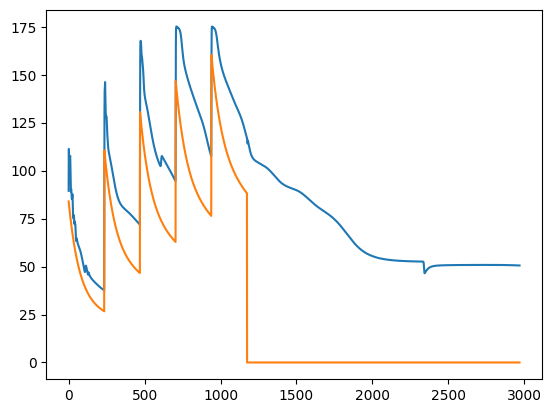

In [21]:
plt.plot(all_predictions[100])
plt.plot(all_targets[100])

In [18]:
masks.sum(axis=1)

tensor([[2790.],
        [2005.],
        [1520.],
        [2460.],
        [1110.],
        [1015.],
        [ 970.],
        [ 950.],
        [2975.],
        [3115.],
        [3225.],
        [1075.],
        [2745.],
        [2860.],
        [1175.],
        [2640.],
        [3255.],
        [1045.],
        [3110.],
        [2685.],
        [2295.],
        [1750.],
        [1505.],
        [1645.],
        [1740.],
        [2230.],
        [2395.],
        [1860.],
        [ 975.],
        [3360.],
        [2095.],
        [1280.]], device='cuda:0')